<a href="https://colab.research.google.com/github/MarioQFFF/LHCb_2023.ipynb/blob/main/GWassignmentWeek3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries
from scipy import interpolate
import numpy as np
from pycbc import frame
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d
from pycbc.filter import highpass
from pycbc import types 
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.waveform import get_td_waveform
import pycbc.psd

In [ ]:
#Resources: Chat GPT was used in the last exercise of part 2 in order to correct an unkown error.
#https://github.com/LLBockenhoff/PRA3024/blob/main/Assignment_nb1.ipynb
#Obviously the hints provided and examples were used.

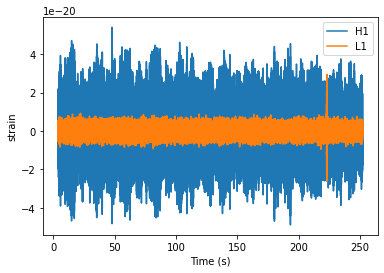

In [ ]:
#Problem 1
d = np.load('/content/drive/MyDrive/Colab Notebooks/GW_noisedata-2.npy') #name of the data file noise_ts_4096Hz.npy
dt = d[:, 0]
data_H1 = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
data_L1 = pycbc.types.TimeSeries(d[:, 2], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
merger = Merger("GW170817")
strain, stilde = {}, {}
strain['H1'] = resample_to_delta_t(highpass(data_H1, 15.0), 1.0/2048)
strain['L1'] = resample_to_delta_t(highpass(data_L1, 15.0), 1.0/2048)

strain['H1'] = strain['H1'].crop(4, 4)
strain['L1'] = strain['L1'].crop(4, 4)

stilde['H1'] = strain['H1'].to_frequencyseries()
stilde['L1'] = strain['L1'].to_frequencyseries()
#print (strain.delta_t)
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()


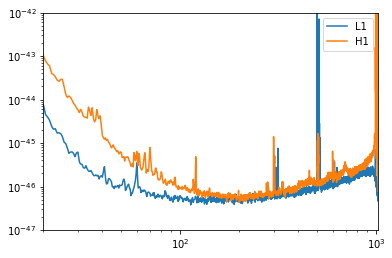

In [ ]:
#first plot the power spectral density of the data
#it is important to whiten the data or in order to find the SNR
import pycbc.psd
from pycbc.psd import interpolate

psds = {}
for ifo in ['L1', 'H1']:

    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend()

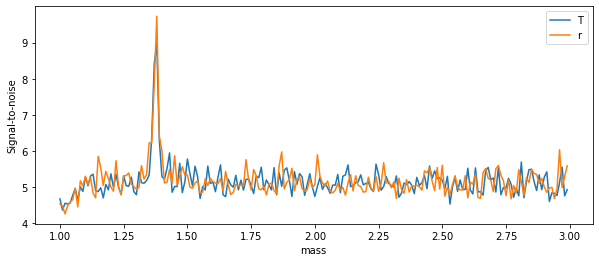

In [ ]:

from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy

# We will try different component masses and see which gives us the largest 

mass1 = numpy.arange(1, 3, 0.01) #mass range bewteen 30 to 40 Solar mass
mass2 = mass1

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}
ifo = 'H1'
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=20.0)
    # We will resize the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0)

    # Remove time corrupted by the template filter and the psd filter
    # We remove 4 seonds at the beginning and end for the PSD filtering
    # And we remove 4 additional seconds at the beginning to account for
    # the template length (this is somewhat generous for 
    # so short a template). A longer signal such as from a BNS, would 
    # require much more padding at the beginning of the vector.
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list



ifo = 'L1'
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=20.0)

    # We will resize the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=20.0)

    # Remove time corrupted by the template filter and the psd filter
    # We remove 4 seonds at the beginning and end for the PSD filtering
    # And we remove 4 additional seconds at the beginning to account for
    # the template length (this is somewhat generous for 
    # so short a template). A longer signal such as from a BNS, would 
    # require much more padding at the beginning of the vector.
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list


# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

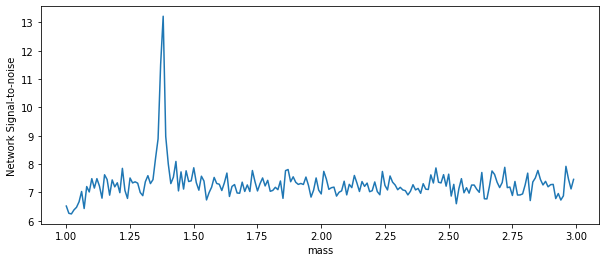

We found the best Mass1=Mass2 was 1.38 solar masses (detector frame)


In [ ]:
nsnr = (numpy.array(snrs['H1'])**2 + numpy.array(snrs['L1'])**2)**0.5
ii = numpy.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

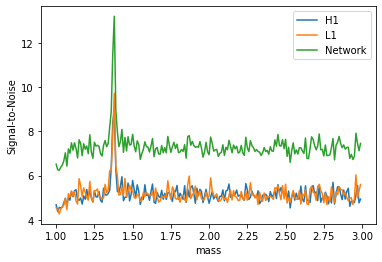

We found the best Mass1=Mass2 was 1.38 solar masses (detector frame)


In [ ]:

# Calculate network noise-to-signal ratio and plot it, so we can see that nsnr > 8, so we have a significant signal there, at mass 1.38
nsnr = (np.array(snrs['H1'])**2 + np.array(snrs['L1'])**2)**0.5
ii = np.where(nsnr == max(nsnr))
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.plot(mass1, nsnr, label='Network')
pylab.legend()

pylab.ylabel('Signal-to-Noise')
pylab.xlabel('mass')
pylab.show()
print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)"% mass1[ii])

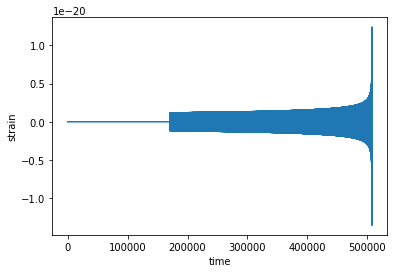

In [ ]:
#creating gw waveform 
m = 1.38
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20.0)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# This function rotates the vector by a fixed amount of time.
# It treats the data as if it were on a ring. Note that
# time stamps are *not* in general affected, but the true
# position in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()


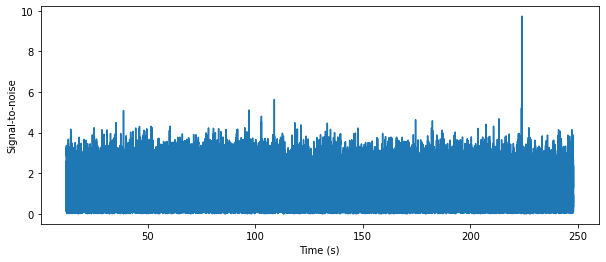

We found a signal at 224.02490234375s with SNR 9.725701597406236


In [ ]:
from pycbc.filter import matched_filter
import numpy
ifo = 'L1'                            
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [ ]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

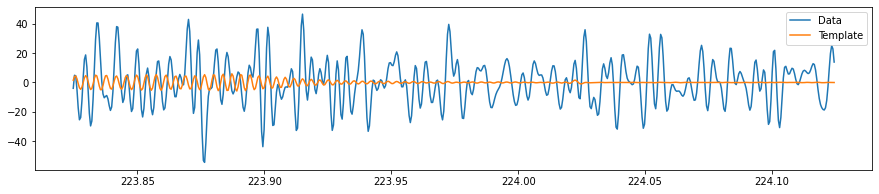

In [ ]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(time-0.2, time+0.1)
white_template = white_template.time_slice(time-0.2, time+0.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()


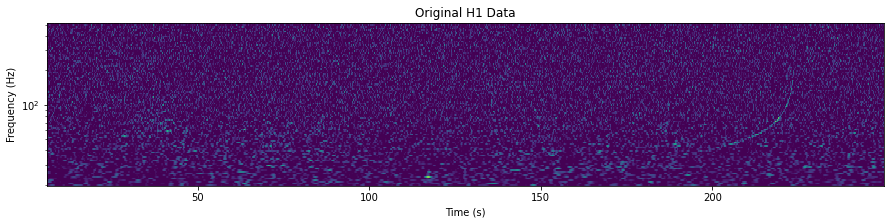

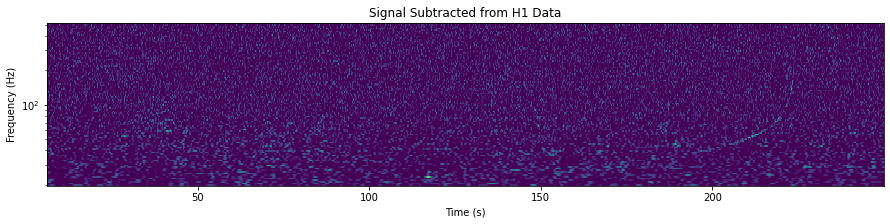

In [ ]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.01,
                                                  logfsteps=100,
                                                  qrange=(110,110),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    #pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()

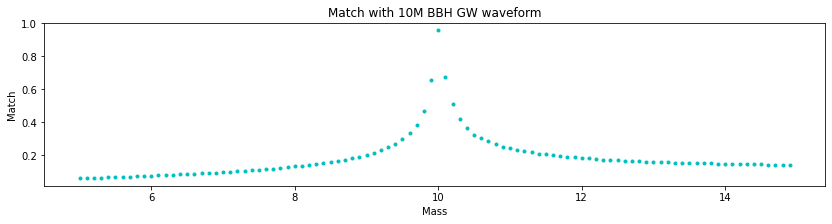

In [ ]:

from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

f_low = 20
sample_rate = 4096
masses = np.arange(5,15,0.1)
matches = {}

for mass in masses:
  # Generate the two waveforms to compare
  hp, hc = get_td_waveform(approximant="EOBNRv2",
                          mass1=10,
                          mass2=10,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  sp, sc = get_td_waveform(approximant="TaylorT4",
                          mass1=mass,
                          mass2=mass,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  # Resize the waveforms to the same length
  tlen = max(len(sp), len(hp))
  sp.resize(tlen)
  hp.resize(tlen)

  # Generate the aLIGO ZDHP PSD
  delta_f = 1.0 / sp.duration
  flen = tlen//2 + 1
  psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

  # Note: This takes a while the first time as an FFT plan is generated
  # subsequent calls are much faster.
  m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
  matches[mass]=m

pylab.figure(figsize=[14, 3])
pylab.title("Match with 10M BBH GW waveform")
pylab.ylabel('Match')
pylab.xlabel('Mass')
pylab.plot(*zip(*matches.items()),'c.')
pylab.show()
     

In [ ]:

#Problem 2
#first download the data from the assignament 
d = np.load('/content/drive/MyDrive/Colab Notebooks/noise_ts_4096Hz.npy') #name of the data file noise_ts_4096Hz.npy
time = d[:, 0]
strain = d[:, 1] 
d = types.TimeSeries(strain, delta_t = time[1]- time[0]) #this is to comvert data into GW timeSeries
data = d
strain=resample_to_delta_t(highpass(data, 15.0), 1.0/2048).crop(4,4)#applying an high pass filter and downsampling
stilde=strain.to_frequencyseries()

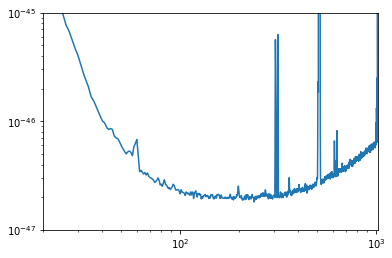

In [ ]:
psds = interpolate(welch(d), 1.0 / d.duration)

pylab.loglog(psds.sample_frequencies, psds, label = "PSD")
pylab.xlim(20, 1024)
pylab.ylim(1e-47, 1e-45)
pylab.show()

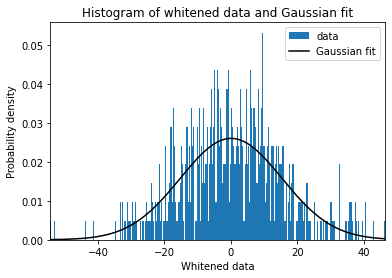

In [ ]:
import numpy as np
import pylab
from scipy.stats import norm
import pycbc.psd 

# Whitening the data (I get an error on the line below, I do not understand  why, and it was taken directly from the hints,
#however I commented it out and the code still worked, now I re-run the code and I got a fifferent graph )
#white_data = (d.to_frequencyseries() / psds[ifo]**0.5).to_timeseries() 

# Computing the histogram of the whitened data, even though I could not run the line above.
hist, bins, _ = pylab.hist(white_data, bins=300, density=True, label='data')

# Fitting a Gaussian distribution to the whitened data
mean, sd = norm.fit(white_data)
x = np.linspace(bins[0], bins[-1], 1000)
gauss = norm.pdf(x, mean, sd)

# Plotting the histogram and the fitted Gaussian distribution
pylab.plot(x, gauss, 'k', label='Gaussian fit')
pylab.xlim(bins[0], bins[-1])
pylab.legend()
pylab.xlabel('Whitened data')
pylab.ylabel('Probability density')
pylab.title('Histogram of whitened data and Gaussian fit')
pylab.show()

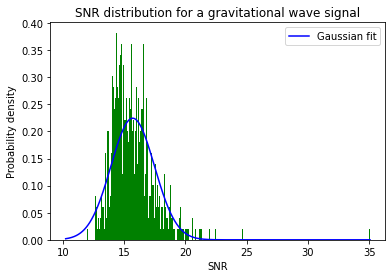

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from pycbc.waveform import get_fd_waveform
from pycbc.psd import interpolate, welch
from pycbc.filter import sigmasq

# Create a waveform to experiment on
hp, hc = get_fd_waveform(approximant="TaylorF2",
                         mass1=3,
                         mass2=3,
                         delta_f=1.0/200.0,
                         distance=500,
                         f_lower=20.0,
                         f_final=2048.0) #Luminosity distance = 500 Mpc

# Slice the data and estimate the PSD for each slice
#Here I sliced the data and initialised SNRlist
data_slice = len(data) // 1000
SNRlist = []

for i in range(1000):
    data_chunk = data[i * data_slice: (i+1) * data_slice]
    psds = interpolate(welch(data_chunk), hp.delta_f)
    SNR = sigmasq(hp, psds) ** 0.5
    SNRlist.append(SNR)

# Plotting histogram
plt.hist(SNRlist, bins=500, density=True, color='green')

# Compute mean and standard deviation of the SNR values
mu, sigma = np.mean(SNRlist), np.std(SNRlist)

# Plotting the best fit Gaussian distribution
x = np.linspace(min(SNRlist), max(SNRlist), 1000)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, color='blue', label='Gaussian fit')

# Add title and axis labels
plt.title('SNR distribution for a gravitational wave signal')
plt.xlabel('SNR')
plt.ylabel('Probability density')
plt.legend()

# Show plot
plt.show()

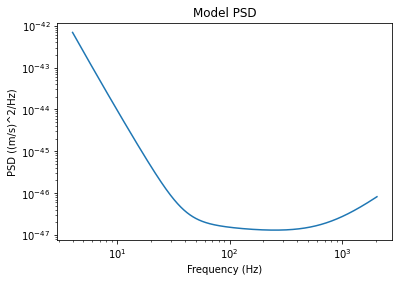

In [ ]:
#Problem 3
import numpy as np
import matplotlib.pyplot as plt
from pycbc.psd import aLIGOZeroDetHighPower

# Set up the lower cutoff frequency and delta f
flow = 4.0
delta_f = 1.0 / 16

# Compute the length of the PSD array and create the PSD object
flen = int(2048.0 / delta_f) + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, flow)

# Set values outside the frequency range to infinity
psd.data[:int(flow/delta_f)] = np.inf
psd.data[-1] = np.inf

# Plot the PSD on a log-log scale
plt.loglog(psd.sample_frequencies, psd)

# Add title and axis labels
plt.title('Model PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ((m/s)^2/Hz)')

# Show plot
plt.show()

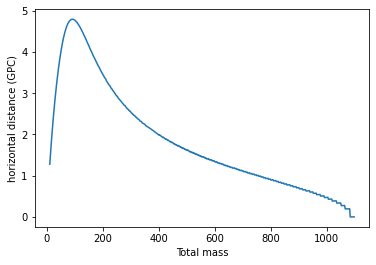

In [ ]:
flow = 4.0 #Hz

masses = np.arange(5,550,1)
#setting the abitrary distance 
abDist = 1000

yplot = []
xplot = []

# Looping over the masses and creating the SNR for each mass
for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, 
                              delta_f=delta_f,
                              distance = abDist)

  SNR = (pycbc.filter.sigmasq(hp, psd))**0.5
  
  # append the SNR/8 for 1 Gpc is the unit of the abitrary distance 
  yplot.append(SNR/8)
  # append m*2 for (m1 + m2) will be plotted 
  xplot.append(m*2)

pylab.plot(xplot, yplot)
pylab.ylabel('horizontal distance (GPC)')
pylab.xlabel('Total mass(m1+m2)')
pylab.show()

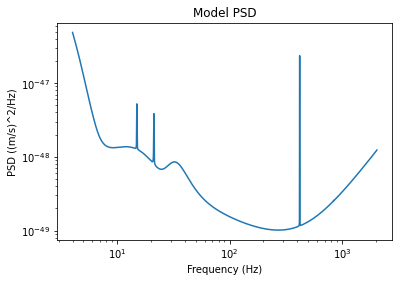

In [ ]:
import pycbc.psd 
import numpy as np 
flow = 4.0   # set up the lower cut off frequency 
delta_f = 1.0 / 16 
flen = int(2048.0/ (delta_f)) + 1 
psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow) 
 
psd.data[:int(flow/delta_f)] = np.inf  #set the value outside the frequency range to infinity 
psd.data[-1] = np.inf 
pylab.loglog(psd.sample_frequencies, psd)
plt.title('Model PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ((m/s)^2/Hz)')
pylab.show()

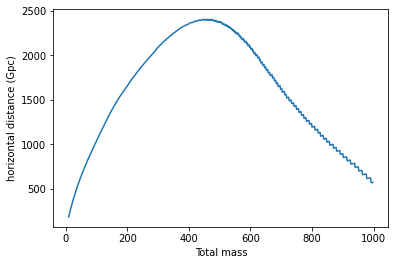

In [ ]:

flow = 4.0 #Hz

masses = np.arange(5,500,1)

yplot = []
xplot = []

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, 
                              delta_f=delta_f,
                              distance = 100)

  SNR = (pycbc.filter.sigmasq(hp, psd))**0.5
  
  yplot.append(SNR/8)
  xplot.append(m*2)

pylab.plot(xplot, yplot)
pylab.ylabel('horizon distance(Gpc)')
pylab.xlabel('Total mass(m1 + m2)')
pylab.show()